<a href="https://colab.research.google.com/github/sumu97/Data-Science-Cheat-Code/blob/main/GameMarket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 게임 시장 분석 프로젝트

## 목적 : 다음 분기에 어떤 게임을 설계해야 하는지에 대한 Insight 도출

  - 반드시 포함되어야 하는 내용
    1. 지역에 따라 선호하는 게임 장르가 다를까?
      - 지역 별 선호하는 게임 시각화 / 완료
      - 지역 별 클러스터링
    2. 연도별 게임의 트렌드가 있을까?
      - 연도 별 클러스터링
    3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스
      - 출고량 별 클러스터링 (4p)

  - 분석 진행 순서
    1. EDA 데이터 전처리 과정 / 완료
      - K 나 M 으로 표시, 분명 수치형 데이터인데 object로 남아있는 feature 들 수정
    2. 지역 - 장르 연관성 분석 및 시각화
      - 시각화는 완료, 연관성 분석은 어떻게? / 50%
    3. 연도별, 장르 별 출고량 시각화
    4. 출고량 계층별 분석 및 개별분석
    5. 결론

  - 참고
    - Sales Feature 의 1 단위는 백만임. 산안드레스 판매량 20.81, 실제 판매량 2750만
    - 시각화는 나중에 몰아서 하자. 시간 비효율적
    - 질문 : 장르별로, 출시에 가장 적합한 플랫폼은 어디일까?
    - 금요일 목표 : 시각화는 충분히 했고, 카이스퀘어 검정, T test 등 sprint 2 에서 배웠던 내용들을 활용해보자.

지역에 따라서 선호하는 게임 장르가 다를까 라는 질문에 대답을 하셔야합니다.\
연도별 게임의 트렌드가 있을까 라는 질문에 대답을 하셔야합니다.\
출고량이 높은 게임에 대한 분석 및 시각화 프로세스가 포함되어야 합니다.

EDA

In [3]:
# 0. 데이터 불러오기

import pandas as pd

url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv' # URL로 데이터셋 불러오기
df = pd.read_csv(url)
df = df.drop(df.columns[0],axis = 1) # 불러온 데이터의 인덱스 열 중복되어 삭제

In [4]:
# 1. Income 데이터 수치화 (object -> int / float)
def floater(col):
  temp_list = []  # 빈 리스트 준비

  for i in col:
    try: # 바로 실수화 가능한 애들 실수화
      temp = float(i)
      temp_list.append(temp) # 실수화 된 넘 리스트에 추가
      #print(temp,'실수처리')
    except: # 바로 실수화가 안된다면? k 든 m 이든 붙어있을 것
      temp = i.replace("K", "000")
      temp = temp.replace("M", "")
      temp = float(temp) # K, M  수치화하여 실수화
      temp_list.append(temp)
      #print(temp,'수식처리')
  return temp_list 

df['NA_Sales'] = floater(df['NA_Sales'])
df['EU_Sales'] = floater(df['EU_Sales'])
df['JP_Sales'] = floater(df['JP_Sales'])
df['Other_Sales'] = floater(df['Other_Sales'])
# 데이터 Value 수정 끝!

활용할 사용자 함수 선언

In [5]:
import numpy as np
import matplotlib.pyplot as plt
 # 그룹화 함수
def group_by(country, value, sorting = 1): # 입력 예시 : df.NA_Sales, df.Genre
  dfv = country.groupby(value).sum()
  dfv = dfv.to_frame(name='Value')
  # sorting = {1, 2, 0} = 내림차순(기본), 오름차순, sort 안함
  if(sorting == 1):
    dfv = dfv.sort_values(by=['Value'],axis = 0, ascending=False) # 높은값이 위로
  elif(sorting == 2):
    dfv = dfv.sort_values(by=['Value'],axis = 0, ascending=True) # 낮은값이 위로
  elif(sorting == 0):
    sorting = 0
  return dfv

 # bar 그라데이션 함수 (긁어옴)
def gradientbars(bars,cmap):
    grad = np.expand_dims(np.linspace(0,1,64),0).T ## 그라데이션을 적용할 컬러 값
    ax = bars[0].axes ## 막대기가 그려진 axes를 가져온다. 이 axes위에 그라데이션을 그린다.
    lim = ax.get_xlim()+ax.get_ylim() ## 처음 바 차트가 그려진 x좌표와 y좌표를 저장
    for bar in bars:
        bar.set_facecolor("none") ## 막대기의 색상을 비워준다.
        x,y = bar.get_xy() ## 막대기의 좌측 하단 x, y좌표
        w, h = bar.get_width(), bar.get_height() ## 막대기의 폭과 높이
        ax.imshow(grad, extent=[x,x+w,y+h,y], cmap = cmap, aspect="auto",\
                   vmin=-0.5, vmax=2) ## 막대기안에 그라데이션을 그려준다.
    ax.axis(lim) ## 처음에 그린 바차트의 x좌표 한계값과 y좌표 한계값을 적용한다.

 # Basic Bar Chart 시각화 함수
def bbc(group,title): # 입력 예시 : NA_G, "NA Game Sales By Genre"
  plt.figure(figsize=(15,3))
  plt.title(title, fontsize=15)
  bar = plt.bar(x = group.index, height = group.Value, width = 0.5, bottom = 0) ## 바차트 출력
  cmap = plt.get_cmap('YlOrRd') ## 그라데이션 색상
  gradientbars(bar,cmap)
  plt.show()

# Q1. 지역별로 선호하는 장르가 다를까?
  1. 시각화 (Basic Bar Chart)
  2. ANOVA test

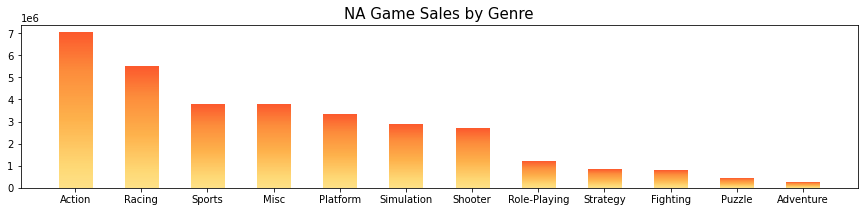

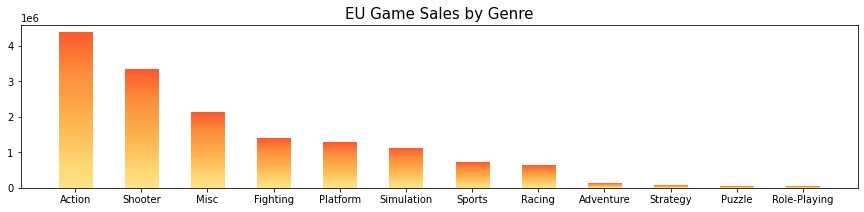

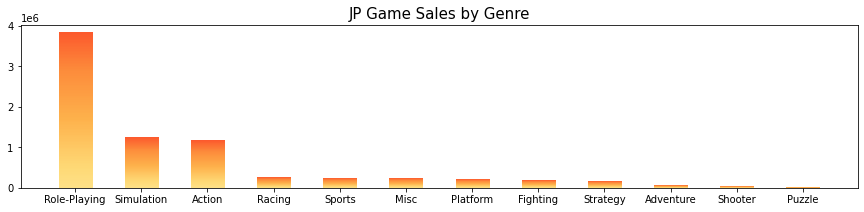

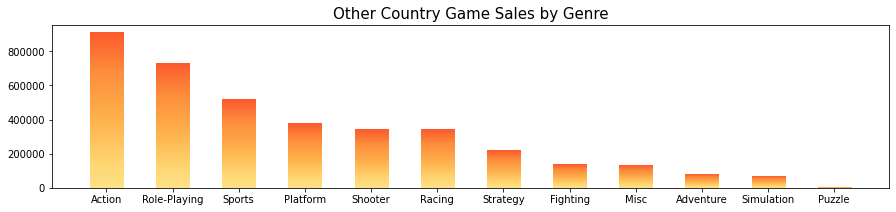

In [6]:
# NA
NA_G = group_by(df.NA_Sales, df.Genre)
bbc(NA_G,"NA Game Sales by Genre")

# EU
EU_G = group_by(df.EU_Sales, df.Genre)
bbc(EU_G,"EU Game Sales by Genre")

#JP
JP_G = group_by(df.JP_Sales, df.Genre)
bbc(JP_G,"JP Game Sales by Genre")

#OT
OT_G = group_by(df.Other_Sales, df.Genre)
bbc(OT_G,"Other Country Game Sales by Genre")

그래프를 보면 지역별로 선호하는 장르가 뚜렷하게 다르다.\
상위 3개 장르를 보면\
북미 : 액션, 레이싱, 스포츠\
유럽 : 액션, 슈터, Misc\
일본 : 롤플레잉, 시뮬레이션, 액션\
기타 : 액션, 롤플레잉, 스포츠\
ANNOVA Test 로 통계적으로 접근해보자. (아래)

In [7]:
# 데이터의 등분산성 확인
from scipy.stats import normaltest
import numpy as np


from scipy.stats import normaltest
import numpy as np

sample = np.random.poisson(5, 1000) # normal 분포가 아님
normaltest(sample)
sample2 = np.random.normal(size = 1000) # normal 분포
normaltest(sample2)

NormaltestResult(statistic=0.5558731703792652, pvalue=0.757344846871407)

In [11]:
# 그룹바이 전체 값에서 각 value 나눠서 퍼센트 feature 추출 (데이터 정규화, 지역별로 총 매출이 다르니..)
NA_G = group_by(df.NA_Sales, df.Genre, sorting=0)
NA_G.Value.sum()
percent_list = []
for i in NA_G.Value:
  result = i / NA_G.Value.sum()
  percent_list.append(result)
NA_G['Value'] = percent_list

EU_G = group_by(df.EU_Sales, df.Genre, sorting=0)
EU_G.Value.sum()
percent_list = []
for i in EU_G.Value:
  result = i / EU_G.Value.sum()
  percent_list.append(result)
EU_G['Value'] = percent_list

JP_G = group_by(df.JP_Sales, df.Genre, sorting=0)
JP_G.Value.sum()
percent_list = []
for i in JP_G.Value:
  result = i / JP_G.Value.sum()
  percent_list.append(result)
JP_G['Value'] = percent_list

OT_G = group_by(df.Other_Sales, df.Genre, sorting=0)
OT_G.Value.sum()
percent_list = []
for i in OT_G.Value:
  result = i / OT_G.Value.sum()
  percent_list.append(result)
OT_G['Value'] = percent_list

# Tidy data로 변환
Genre_df = pd.DataFrame({'NA':NA_G.Value.values.tolist(),
                         'EU':EU_G.Value.values.tolist(),
                         'JP':JP_G.Value.values.tolist(),
                         'OT':OT_G.Value.values.tolist()})
Genre_df.index = NA_G.index
Genre_df.reset_index(drop=False, inplace=True)
Genre_melt = pd.melt(Genre_df.reset_index(), id_vars=['Genre'], value_vars=['NA','EU','JP','OT'])
Genre_melt.columns = ['Genre','Location','Percent']
Genre_melt

# Normaltest
from scipy.stats import normaltest
Genre_df.index = Genre_df.Genre
Genre_df = Genre_df.drop(['Genre'], axis=1)
print("Normal Test 결과 :")
print(normaltest(Genre_df))

# ANOVA TEST
from scipy import stats
fvalue, pvalue = stats.f_oneway(Genre_df['NA'], Genre_df['EU'], Genre_df['JP'], Genre_df['OT'])
print('ANOVA Test 결과 :')
print(' F-value=',fvalue,'\n','P-Value=',pvalue)
stats.f_oneway(Genre_df['NA'], Genre_df['EU'], Genre_df['JP'], Genre_df['OT'])

Normal Test 결과 :
NormaltestResult(statistic=array([ 1.29753284,  5.09133524, 23.55273232,  2.77331063]), pvalue=array([5.22690159e-01, 7.84206795e-02, 7.68403193e-06, 2.49909777e-01]))
ANOVA Test 결과 :
 F-value= 1.2752897872324998e-32 
 P-Value= 1.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


F_onewayResult(statistic=1.2752897872324998e-32, pvalue=1.0)

In [12]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
model = ols('Percent ~ C(Location) * C(Genre)', Genre_melt).fit()
anova_lm(model)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/anova.py:140: RuntimeWarning: divide by zero encountered in double_scalars
  (model.ssr / model.df_resid))


,df,sum_sq,mean_sq,F,PR(>F)
C(Location),3.0,2.797413e-32,9.324711e-33,0.0,NaN
C(Genre),11.0,1.833245e-01,1.666586e-02,0.0,NaN
C(Location):C(Genre),33.0,2.365923e-01,7.169463e-03,0.0,NaN
Residual,0.0,3.494880e-30,inf,NaN,NaN


등분산성을 확인하기 위해 Normal Test 수행결과, JP를 제외한 나머지는 비슷한 분산을 가지고 있음\
지역별 차이를 확인하기 위해 ANOVA Test 수행결과 P-Value 가 Nan이나 1이 나오는걸로 봐서,\
시각화로 얻어낸 결론과 동일하게 지역별로 선호하는 장르는 서로 독립적이다.

# Q2. 연도별 게임의 트렌드가 있을까??
  1. 시각화 (Heatmap)
    1. 출시 장르 시각화
    2. 매출 장르 시각화
      1. 해당 연도 데이터를 모아서
      2. 장르별로 Total_sales를 묶고
      3. 데이터프레임에 반영

In [117]:
grouped = abalone['whole_weight'].groupby(abalone['sex'])
grouped 
<pandas.core.groupby.SeriesGroupBy object at 0x112668c10>
grouped.size()

grouped.sum()

grouped.mean()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0.00,0.00,0.00,0.04
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


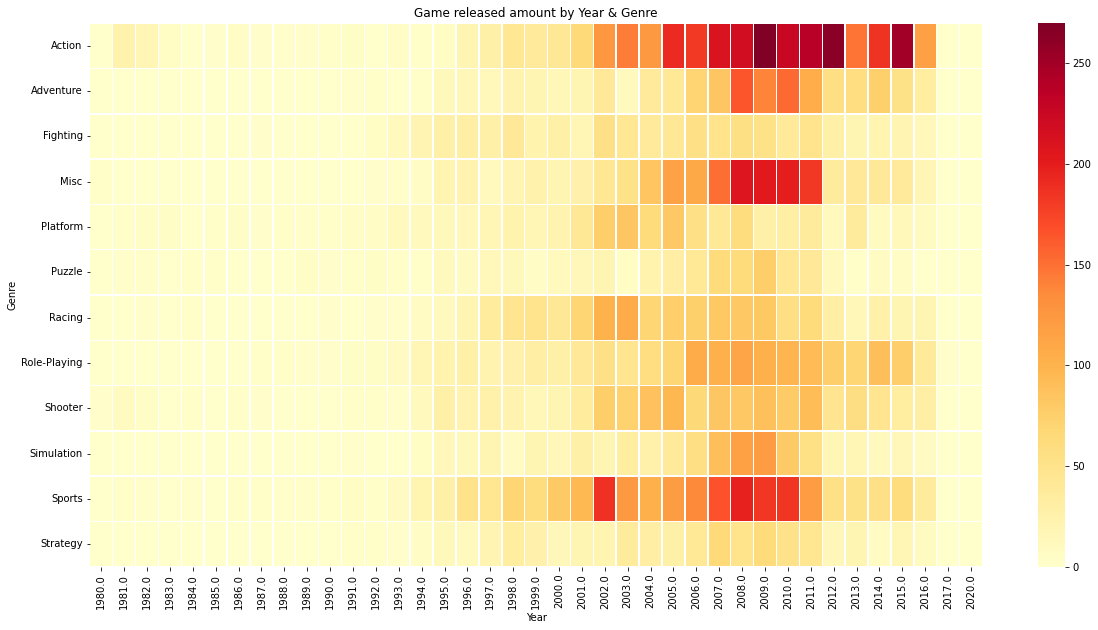

In [133]:
# 연도,장르별 출시량 시각화 
# 1 : 그 가로세로 짬짜미(pd.crossstab)한걸로 연도랑 장르 긁어서 표시
# 2 : 그거 시각화
import seaborn as sns
year_G = pd.crosstab(df.Genre, df.Year)
year_G = year_G.drop(year_G.columns[0:23],axis = 1)
plt.figure(figsize=(20,10))
plt.title('Game released amount by Year & Genre')
ax = sns.heatmap(year_G, linewidths=.5, cmap='YlOrRd');
# 해당연도 Total Sales 로 나눠서, 데이터를 보면 더 의미있는 결과를 얻을 수 있을듯. 연도별로 뭐가 젤 잘나간지를 아는게 목적이니까

해당연도의 총 판매량에서 각 게임의 판매량을 나눠 판매지분 Feature를 만들어서 계산하면 좀 더 시각화에 유리할 듯.

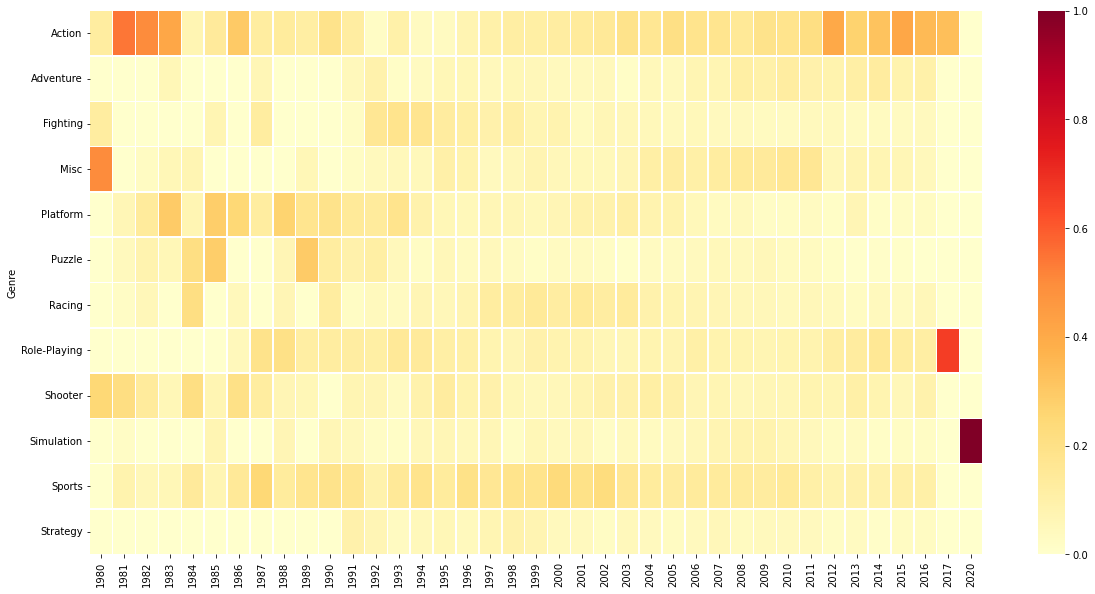

In [132]:
# year_G 를 리스트로 치환, 평균 및 % 연산 후 되돌리는 함수
year_G.columns = stringer(year_G.columns) # year_G 컬럼 타입 스트링으로 변경


def percent(col):
  ls = col.values.tolist() # 컬럼 데이터 리스트로 변경
  #print('ls',ls)
  nls = [] # 새로운 리스트 하나 만들고
  for num in ls:  # 리스트의 원소 하나하나 for 문돌려서
    data = num / np.sum(ls) # 연도에서 몇 % 차지하고 있는지 계산
    nls.append(data) # 계산된 값을 새로운 리스트에 추가
  #print('nls=',nls)
  col = nls # 새로운 리스트를 데이터프레임의 열에 대입
  return col

for columns in year_G.columns:
  year_G[columns] = percent(year_G[columns])
  
plt.figure(figsize=(20,10))
ax = sns.heatmap(year_G, linewidths=.5, cmap='YlOrRd'); # 극단치가 있어서 예상한것만큼 이쁘게 나오지가 않네 (예상한것 : 연도별로 최대치를 1로, 최소치를 0 으로 잡아 시각화)

는 아니였음..\
연도별로 Top Selling 3위만 추려내보자

In [59]:
max_year = year_G.T.max(axis=1)
year_df = pd.DataFrame({'index':max_year.index})
for n in range(3):
  num1 = 0
  num2 = 0
  Ganre = []
  for year in max_year.index: # 1980 ~ 2020 까지 반복문 실행
    num1 = 0 # 아래 for 문에서 활용하는 변수 초기화
    for i in year_G[year]:# 위 연도의 값 첫번째부터 마지막것까지 반복문 실행
      if i ==  sorted(year_G[year], reverse=True)[n]: # i 가 두번째로 큰 값이랑 겹치면
        Ganre.append(year_G.index[num1]) # 인덱스 값(장르) 를 리스트에 추가
        #print(year,"appended = ",year_G.index[num1]) # 디버그 용도 / 왜 오류가 생기나 했더니 공동치가 있네 ㅠㅠ
        break;
      num1+=1 # if문 안들어가면 num 변수 +1
    num2+=1 # 1980 = 0회차, 1981 = 1회차 로 점차 증가 (위의 IF문 연동)
  #print(Ganre)

  year_df[n] = Ganre
year_df = year_df.set_index('index',drop=True, inplace=False)
year_df.columns = range(1,4)
year_df.T

index,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020
1,Misc,Action,Action,Action,Puzzle,Platform,Action,Sports,Platform,Puzzle,Action,Sports,Fighting,Fighting,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Sports,Action,Action,Action,Action,Action,Action,Action,Action,Action,Action,Action,Action,Action,Action,Role-Playing,Simulation
2,Shooter,Shooter,Platform,Platform,Puzzle,Platform,Platform,Role-Playing,Role-Playing,Platform,Action,Platform,Platform,Fighting,Fighting,Fighting,Fighting,Racing,Racing,Racing,Action,Racing,Action,Sports,Sports,Sports,Sports,Sports,Misc,Misc,Misc,Misc,Role-Playing,Role-Playing,Role-Playing,Role-Playing,Role-Playing,Action,Action
3,Action,Sports,Platform,Adventure,Puzzle,Action,Shooter,Action,Action,Platform,Action,Action,Puzzle,Role-Playing,Role-Playing,Fighting,Role-Playing,Action,Action,Action,Action,Action,Racing,Racing,Shooter,Misc,Misc,Misc,Sports,Sports,Sports,Sports,Adventure,Adventure,Adventure,Sports,Sports,Adventure,Action


In [79]:
from sklearn.preprocessing import StandardScaler #표준화 패키지
x = df.loc[:,df.columns].values
x = StandardScaler().fit_transform(x) #스케일링
from sklearn.decomposition import PCA #PCA
pca = PCA(n_components = 2)
pcacomp = pca.fit_transform(x)
pcadf = pd.DataFrame(data = pcacomp, columns = ['pc1','pc2'])

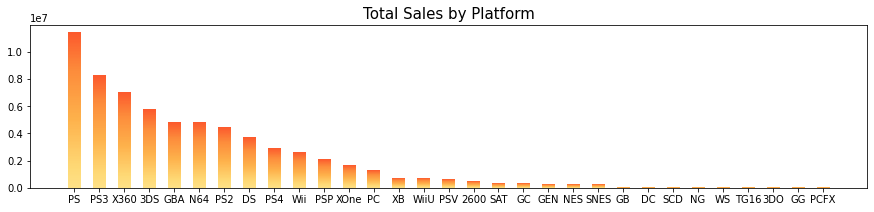

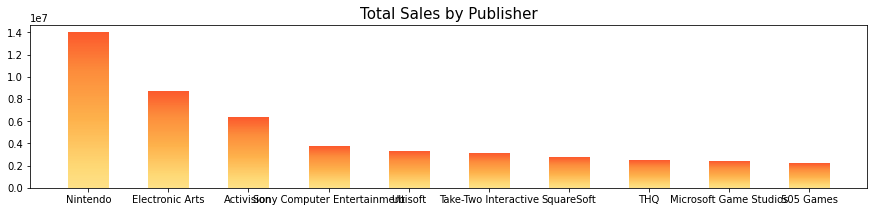

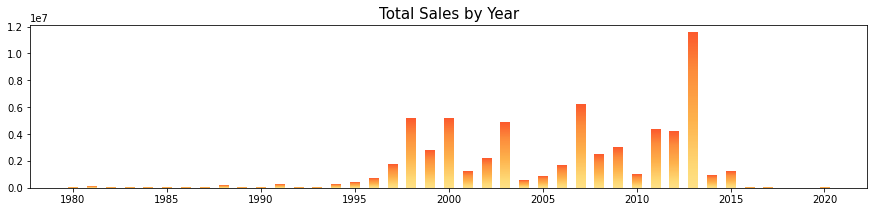

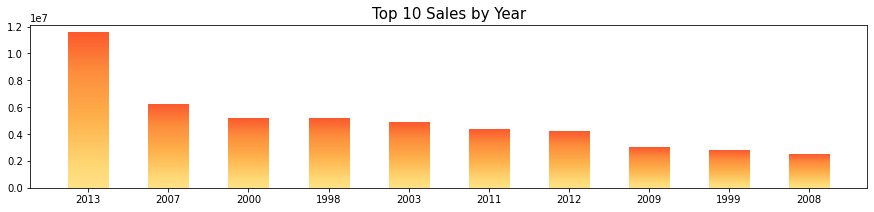

In [18]:
# 게임 플랫폼에 따른 판매량 시각화
# 1. 겜 판매량 총합 Feature df 에 추가
# 2. 그룹바이 후 시각화 (플랫폼, 판매량 Barplot)

 # String 으로 인덱스를 돌려주는 함수
def stringer(col):
  temp_list = []
  for i in col:
    temp = int(i) #.0 붙는거 삭제
    temp = str(temp)
    temp_list.append(temp)
  return temp_list

df['Total_Sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales'] # 1
platform_S = group_by(df.Total_Sales, df.Platform)
bbc(platform_S,'Total Sales by Platform')

# 가장 게임을 잘 팔아치운 퍼블리셔는 누굴까?
# 그룹바이 후 바로 시각화하지말고 Top10만 남기도록 하자
publisher_S = group_by(df.Total_Sales, df.Publisher)
bbc(publisher_S[0:10],'Total Sales by Publisher')

# 연도별로 얼마나 겜이 팔렸을까?
year_S1 = group_by(df.Total_Sales, df.Year ,sorting=0)
bbc(year_S1.drop(year_S1.index[0:23]),'Total Sales by Year')

# 가장 많이 게임이 팔린 연도는 언젤까?
year_S2 = group_by(df.Total_Sales, df.Year, sorting=1)
year_S2 = year_S2.iloc[0:10]
year_S2.index = stringer(year_S2.index)
bbc(year_S2,'Top 10 Sales by Year')

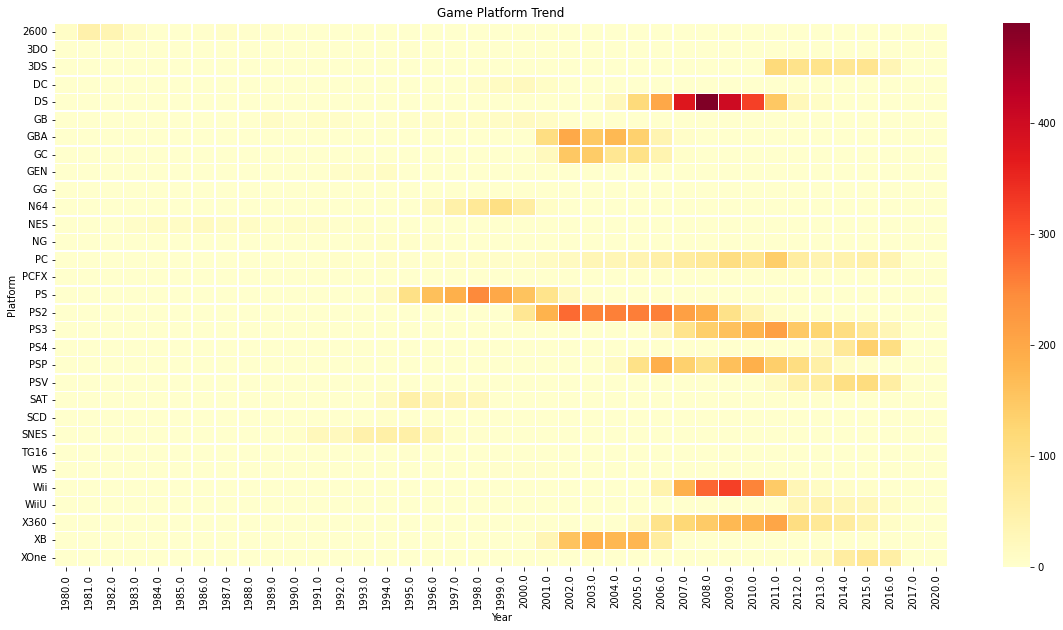

In [128]:
# 게임 플랫폼 트렌드 분석
year_G = pd.crosstab(df.Platform, df.Year)
year_G = year_G.drop(year_G.columns[0:23],axis = 1)
plt.figure(figsize=(20,10))
plt.title('Game Platform Trend')
ax = sns.heatmap(year_G, linewidths=.5, cmap='YlOrRd');